In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

## Carga y Limpieza de Datos
### En esta sección, se carga la información de los cursos desde un archivo CSV y se prepara para el análisis.
### - Los valores de calificación (rating) faltantes se reemplazan con 0.
### - Los valores de calificación se convierten a valores numéricos.
### - El número de reseñas se limpia y se convierte a valores numéricos.

In [24]:
# Cargar el csv
csv_path = 'datos.csv'
df_courses = pd.read_csv(csv_path)

In [25]:
# Fill missing ratings with 0
df_courses['Rating'].fillna(0, inplace=True)
# Limpieza de datos del campo reviews
df_courses['Rating'] = pd.to_numeric(df_courses['Rating'], errors='coerce')
df_courses['Review'] = df_courses['Review'].str.replace(' reviews', '').replace(' review', '').str.replace(',', '').astype('float', errors='ignore')


## Cálculo de la Calificación Promedio
### Aquí, el código calcula la calificación promedio para cada curso agrupando los datos por título del curso.
### Los resultados se muestran en un DataFrame.

In [28]:

# Calculate the average rating for each course
avg_rating_per_course = df_courses.groupby('Course Title')['Rating'].mean().reset_index()
avg_rating_per_course.columns = ['Course Title', 'Average Rating']

# Display the average rating for each course
print("Average Rating for Each Course:")
print(avg_rating_per_course)

Average Rating for Each Course:
                                           Course Title  Average Rating
0      Assisting Public Sector Decision Makers With ...             4.8
1      Atención prehospitalaria del ictus agudo y se...             4.9
2      Build a social media presence for your busine...             4.7
3      Build social awareness content for Twitter wi...             0.0
4      Comercio, Inmigración y Tipos de Cambio en un...             4.9
...                                                 ...             ...
6387                              현대 로봇공학, 강좌 2: 로봇 기구학             0.0
6388                              현대 로봇공학, 강좌 3: 로봇 동역학             0.0
6389                       현대 로봇공학, 강좌 4: 로봇 동작 계획 및 제어             0.0
6390              현대 로봇공학, 강좌 5:  로봇 매니퓰레이션 및 차륜형 이동 로봇             0.0
6391                현대 로봇공학, 강좌 6: 캡스톤 프로젝트, 모바일 매니퓰레이션             0.0

[6392 rows x 2 columns]


## Identificar Cursos con Mayor y Menor Calificación
### Esta parte identifica el curso con la mayor y menor calificación, lo que ayuda a entender la distribución de calidad de los cursos.
## Porcentaje de Cursos con Horario Flexible
### Esta sección calcula el porcentaje de cursos que tienen un horario flexible, útil para evaluar la disponibilidad de los cursos.



In [29]:
# Buscar los crusos con las altos y bajos ratings
highest_rated_course = df_courses.loc[df_courses['Rating'].idxmax()]
lowest_rated_course = df_courses.loc[df_courses['Rating'].idxmin()]

# Calcular el porcentaje de los cursos con horario flexible
flexible_courses = df_courses[df_courses['Schedule'] == 'Flexible schedule']
percent_flexible = round((len(flexible_courses) / len(df_courses)) * 100, 2)

# Resultado del análisis de cursos
print(f"Curso calificado mas alto: {highest_rated_course['Course Title']} con una calificación de {highest_rated_course['Rating']}")
print(f"Curso calificado mas baja: {lowest_rated_course['Course Title']} con una calificación de {lowest_rated_course['Rating']}")
print(f"Porcentaje de cursos flexibles: {percent_flexible}%")

Curso calificado mas alto: Songwriting: Writing the Music con una calificación de 5.0
Curso calificado mas baja: Distribución digital de la música independiente con una calificación de 0.0
Porcentaje de cursos flexibles: 92.88%


## Visualizaciones
### Esta sección crea visualizaciones para obtener más información sobre los datos. Cada gráfico está explicado en los comentarios.

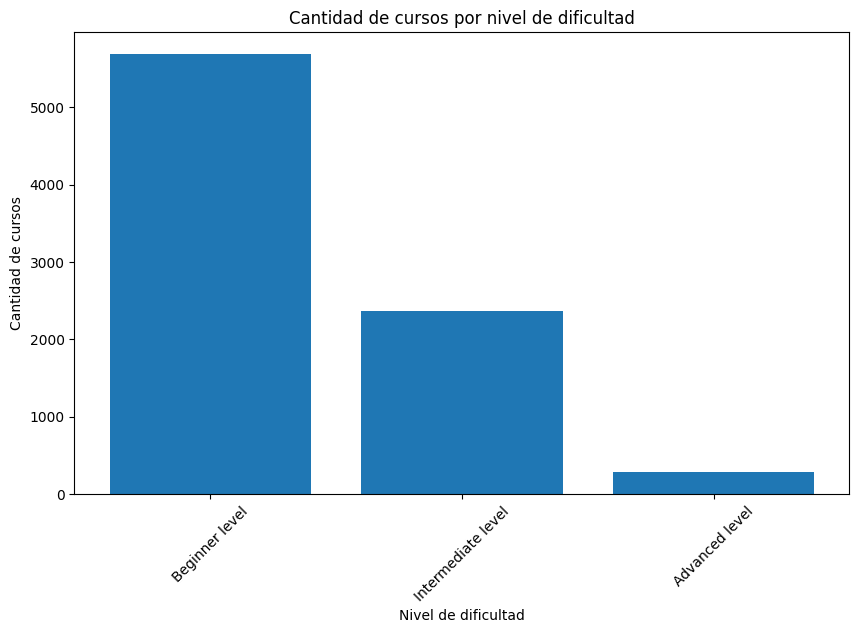

In [30]:
# Gráficas
# 1. gráfica de barras que muestre el número de cursos en cada nivel de dificultad.
difficulty_counts = df_courses['Level'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(difficulty_counts.index, difficulty_counts.values)
plt.title('Cantidad de cursos por nivel de dificultad')
plt.xlabel('Nivel de dificultad')
plt.ylabel('Cantidad de cursos')
plt.xticks(rotation=45)
plt.show()

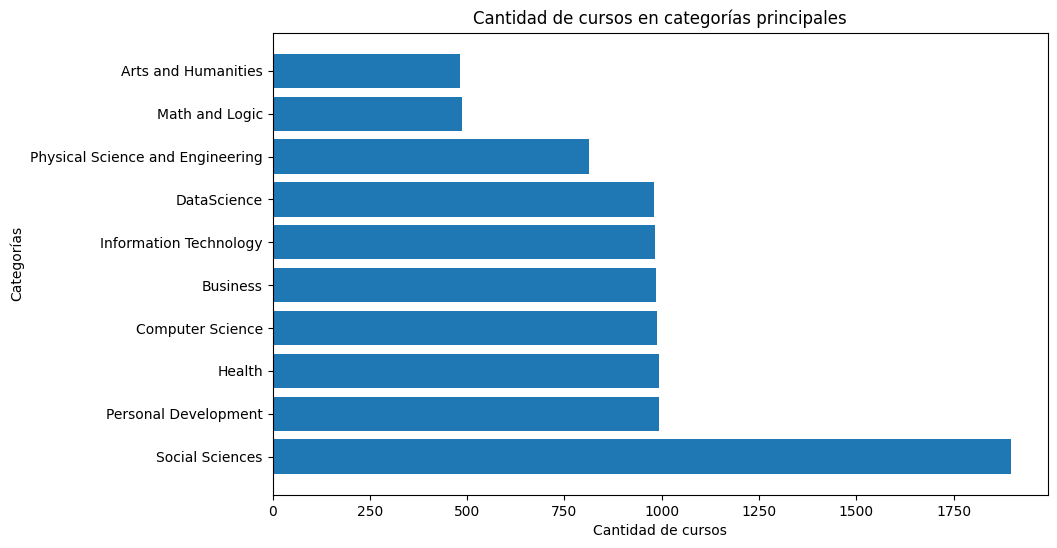

In [31]:
# 2. gráfica de barras horizontal que muestre el número de cursos en las principales categorías
category_counts = df_courses['Keyword'].value_counts().head(10)  # Top 10 categories
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values)
plt.title('Cantidad de cursos en categorías principales')
plt.xlabel('Cantidad de cursos')
plt.ylabel('Categorías')
plt.show()

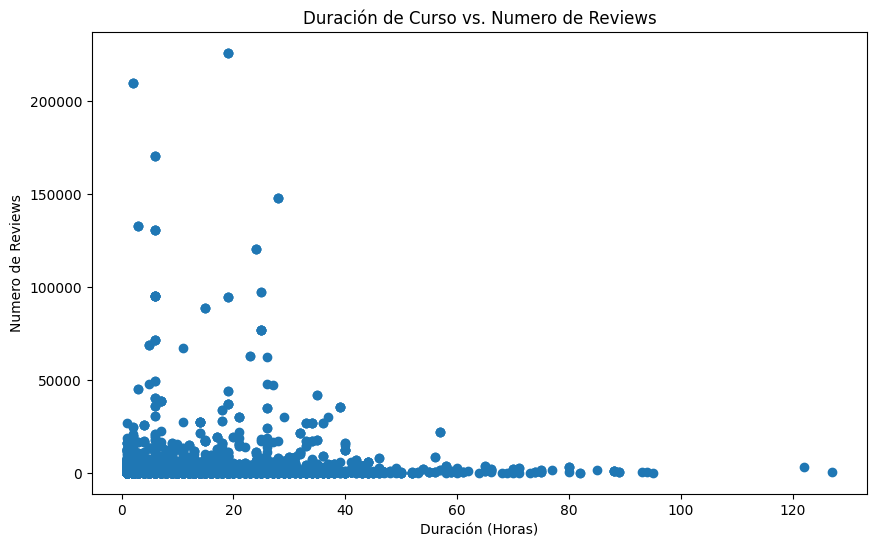

In [32]:
# 3. gráfico de dispersión para visualizar la relación entre la duración del curso y el número de revisiones
df_courses['Duration Hours'] = pd.to_numeric(df_courses['Duration'].str.extract('(\d+)')[0], errors='coerce')
plt.figure(figsize=(10, 6))
plt.scatter(df_courses['Duration Hours'], df_courses['Review'])
plt.title('Duración de Curso vs. Numero de Reviews')
plt.xlabel('Duración (Horas)')
plt.ylabel('Numero de Reviews')
plt.show()

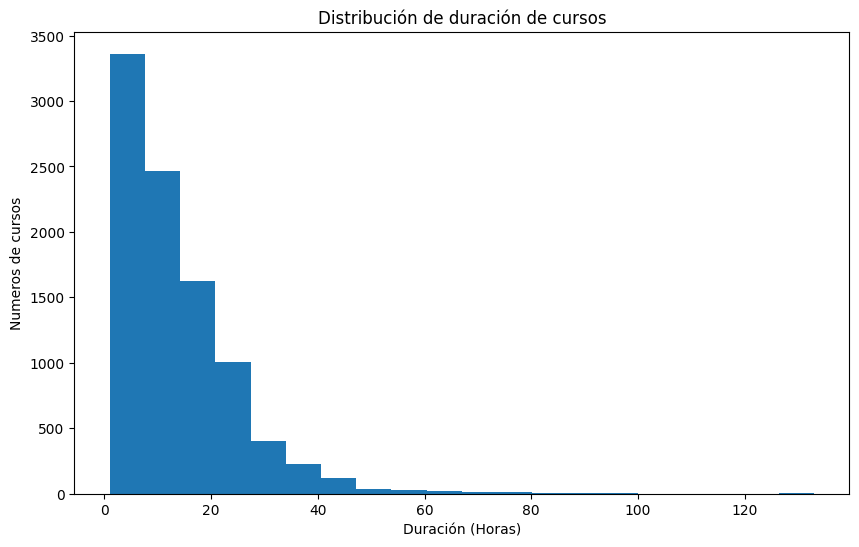

In [33]:
# 4. histograma de la distribución de las duraciones de los cursos
plt.figure(figsize=(10, 6))
plt.hist(df_courses['Duration Hours'].dropna(), bins=20)
plt.title('Distribución de duración de cursos')
plt.xlabel('Duración (Horas)')
plt.ylabel('Numeros de cursos')
plt.show()

<Figure size 1000x600 with 0 Axes>

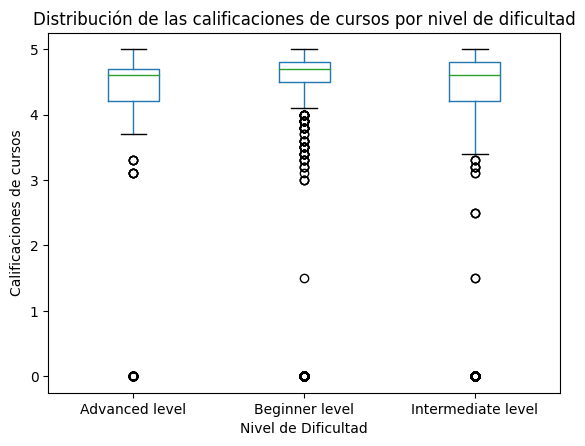

In [34]:
# 5. gráfico de cajas para visualizar la distribución de las calificaciones de los cursos por nivel de dificultad
plt.figure(figsize=(10, 6))
df_courses.boxplot(column='Rating', by='Level', grid=False)
plt.title('Distribución de las calificaciones de cursos por nivel de dificultad')
plt.xlabel('Nivel de Dificultad')
plt.ylabel('Calificaciones de cursos')
plt.suptitle('')
plt.show()

## Análisis de Texto
### Esta sección realiza un análisis de texto en el archivo de comentarios proporcionado.
### - Tokeniza el texto en palabras individuales.
### - Convierte el texto a minúsculas y elimina la puntuación.
### - Elimina las palabras vacías (stopwords) para un análisis más limpio.
### - Aplica lematización y stemming para estandarizar las formas de las palabras.
### - Calcula la frecuencia de palabras y realiza un análisis de sentimientos.

In [35]:
# Cargar el archivo de texto para analizar
txt_path = 'comments.txt'
with open(txt_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [36]:
nltk.download('punkt')

# Tokenizacion
tokens = word_tokenize(text_data)

# Convetir a minusculas y remover signos de puntuación
tokens = [word.lower() for word in tokens if word.isalnum()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
# Eliminación de palabras vacias
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
filtered_tokens = [word for word in tokens if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Lematización y Stemming
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# Frecuencia de palabras
word_freq = Counter(filtered_tokens)
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)
print(f"Top 10 Palabras Más Frecuentes: {word_freq.most_common(10)}")

Top 10 Palabras Más Frecuentes: [('semana', 1641), ('curso', 1324), ('participantes', 837), ('ta', 836), ('dudas', 807), ('portafolio', 796), ('si', 641), ('1', 569), ('foros', 535), ('compañeros', 497)]


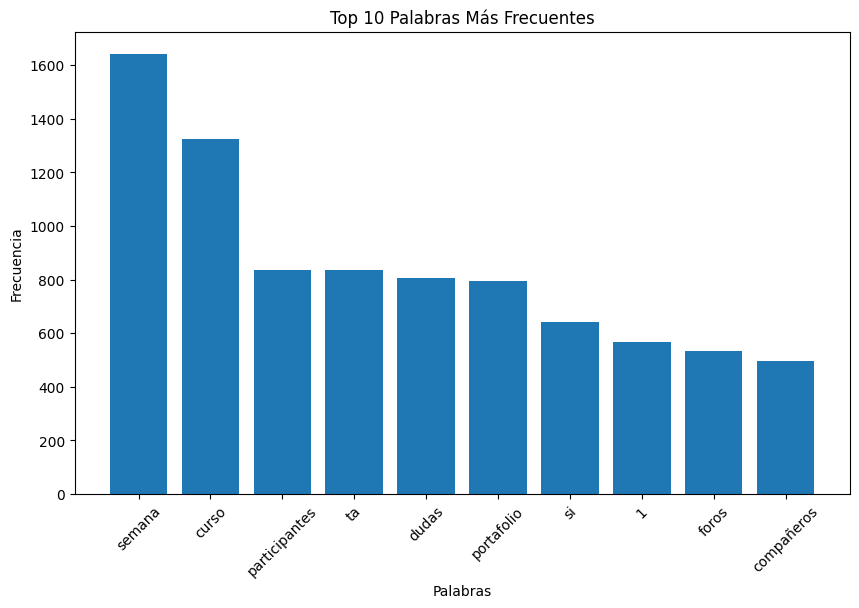

In [42]:
# Gráfico de representación Top 10 preguntas
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Top 10 Palabras Más Frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Puntaje de Sentimientos: {'neg': 0.035, 'neu': 0.954, 'pos': 0.011, 'compound': -1.0}


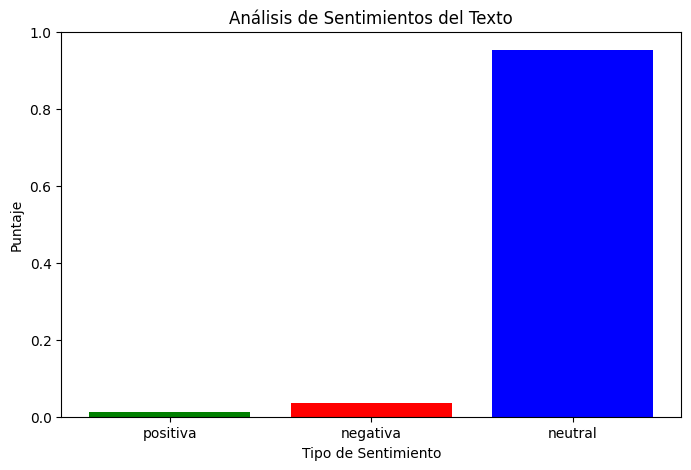

In [43]:
# Analisis de sentimientos
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text_data)
print(f"Puntaje de Sentimientos: {sentiment_scores}")

sentiments = ['positiva', 'negativa', 'neutral']
scores = [sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu']]

plt.figure(figsize=(8, 5))
plt.bar(sentiments, scores, color=['green', 'red', 'blue'])
plt.title('Análisis de Sentimientos del Texto')
plt.xlabel('Tipo de Sentimiento')
plt.ylabel('Puntaje')
plt.show()

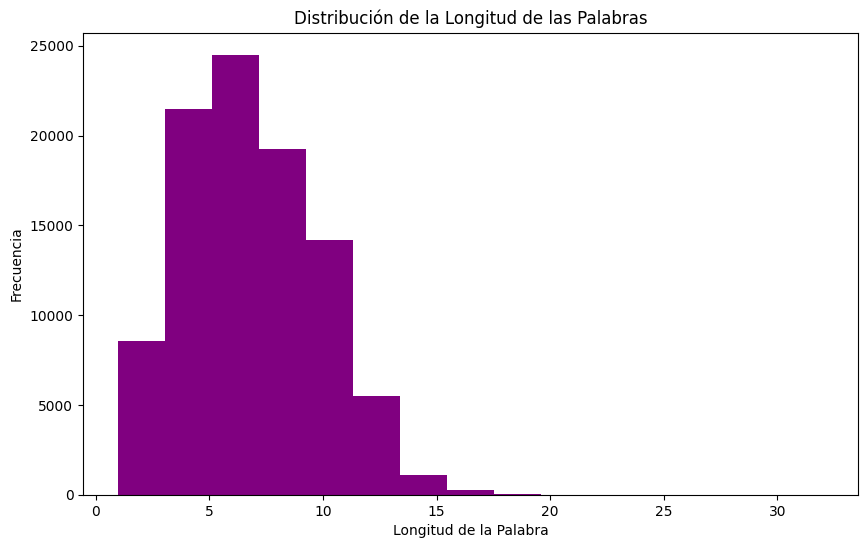

In [44]:
# Gráfico de Distribución de la Longitud de las Palabras
word_lengths = [len(word) for word in filtered_tokens]

plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=15, color='purple')
plt.title('Distribución de la Longitud de las Palabras')
plt.xlabel('Longitud de la Palabra')
plt.ylabel('Frecuencia')
plt.show()

In [46]:
# Reconocimiento de entidades nombradas
names = [word for word in tokens if word.istitle()]
print(f"Entidades extraidas: {names[:10]}")

# Gráfico Top 10 Entidades Nombradas
# name_counts = Counter(names).most_common(10)
# name_words, name_frequencies = zip(*name_counts)

# plt.figure(figsize=(10, 6))
# plt.bar(name_words, name_frequencies)
# plt.title('Top 10 Entidades Nombradas')
# plt.xlabel('Entidades')
# plt.ylabel('Frecuencia')
# plt.xticks(rotation=45)
# plt.show()

Entidades extraidas: []


# Conclusiones
## **Conclusión general del análisis realizado:**

#### A través de este análisis, pudimos obtener información valiosa sobre los cursos, incluyendo las calificaciones promedio, las duraciones y la flexibilidad horaria. Las visualizaciones nos ayudaron a identificar tendencias y distribuciones clave, mientras que el análisis de texto proporcionó información sobre la frecuencia de palabras, sentimientos y entidades nombradas en los comentarios de los usuarios. En general, los datos indican que la mayoría de los cursos tienen horarios flexibles y las calificaciones varían dependiendo de la dificultad y duración del curso.

## **Conclusión sobre el uso de Python en el análisis de datos:**
#### Python demostró ser una herramienta poderosa y versátil para el análisis de datos. Librerías como Pandas y Matplotlib permitieron realizar una limpieza de datos eficiente, cálculos estadísticos, y visualizaciones intuitivas. NLTK fue fundamental para el análisis de texto, facilitando la tokenización, limpieza, análisis de sentimientos y reconocimiento de entidades nombradas. La capacidad de integrar múltiples herramientas en un solo entorno de trabajo hace que Python sea ideal para proyectos de análisis de datos de este tipo.